# Module Dependencies 

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random
import numpy as np
import string
import matplotlib.pyplot as plot
from scipy.stats import kstest,levene,ttest_rel, wilcoxon

#pytorch modules
import torch
from torch import load
from torchvision.utils import save_image
from torchvision import transforms
from torch.nn import MSELoss

#local modules
from configs import *
from utils import create_dirs_logs, compute_fid, compute_mse,save_list_table, analize_table, plot_histogram, draw_red_square, save_list_table
from data.common import unfold_image, fold_image, load_image_to_tensor, attention_mask_from_font
from models import glyphgan as model
from train import train_default
from test import test_default, test_with_metrics


# Train Models

In [ ]:
for seed in range(0,15):
        config=conf_experiment1_var1()
        config['logname']=f'default_seed_{seed}'
        config['seed']=seed
        train_default(config)
for seed in range(0,15):
        config=conf_experiment1_var2()
        config['logname']=f'mask_seed_{seed}'
        config['seed']=seed
        train_default(config)
for seed in range(0,15):
        config=conf_experiment1_var3()
        config['logname']=f'skeleton_seed_{seed}'
        config['seed']=seed
        train_default(config)

# Test Models and compute MSE and FID

In [ ]:
#--------- Generate Test Samples
#Compute MSE and SSIM for each output alongside the overall mean and FID on whole dataset

for seed in range(0,15):
        for letter in list(string.ascii_uppercase):
                config=conf_experiment1_var1()
                config['logname']=f'default_seed_{seed}'
                config['seed']=seed
                config['glyphs_visible']=[list(string.ascii_uppercase).index(letter)]
                test_with_metrics(config,f'{letter}.txt')

for seed in range(0,15):
        for letter in list(string.ascii_uppercase):
                config=conf_experiment1_var2()
                config['logname']=f'mask_seed_{seed}'
                config['seed']=seed
                config['glyphs_visible']=[list(string.ascii_uppercase).index(letter)]
                test_with_metrics(config,f'{letter}.txt')

for seed in range(0,15):
        for letter in list(string.ascii_uppercase):
                config=conf_experiment1_var3()
                config['logname']=f'skeleton_seed_{seed}'
                config['seed']=seed
                config['glyphs_visible']=[list(string.ascii_uppercase).index(letter)]
                test_with_metrics(config,f'{letter}.txt')

# Data Plots

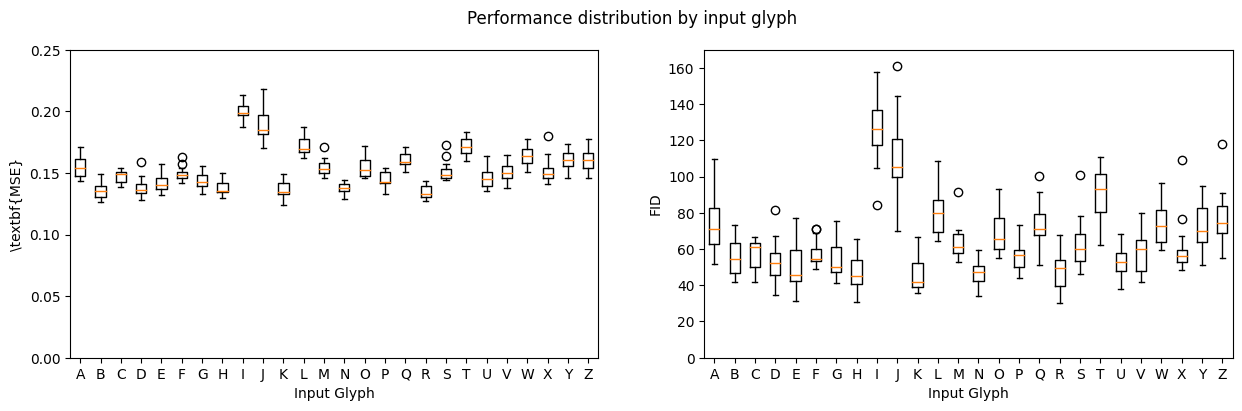

In [2]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)


fig, (ax1, ax2) = plot.subplots(1, 2,figsize = (15,4))
fig.suptitle('Performance distribution by input glyph')
ax1.boxplot(mse_list, labels=list(string.ascii_uppercase))
ax2.boxplot(fid_list, labels=list(string.ascii_uppercase))
ax1.set_ylabel('MSE')
ax2.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax2.set_xlabel('Input Glyph')
ax1.set_ylim([0,0.25])
ax2.set_ylim([0,170])
plot.show()

### Model with masks in loss computation

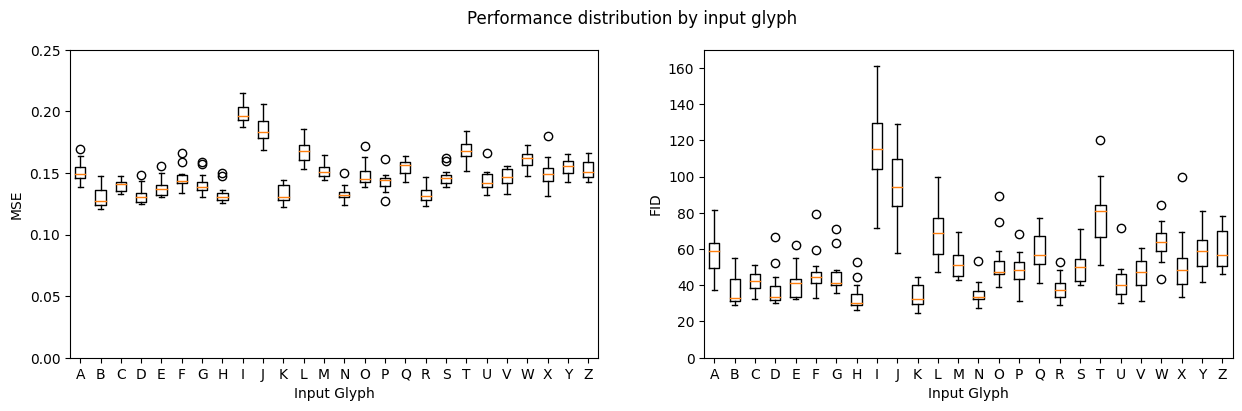

In [33]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/mask_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)


fig, (ax1, ax2) = plot.subplots(1, 2,figsize = (15,4))
fig.suptitle('Performance distribution by input glyph')
ax1.boxplot(mse_list, labels=list(string.ascii_uppercase))
ax2.boxplot(fid_list, labels=list(string.ascii_uppercase))
ax1.set_ylabel('MSE')
ax2.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax2.set_xlabel('Input Glyph')
ax1.set_ylim([0,0.25])
ax2.set_ylim([0,170])
plot.show()

### Model with skeleton masks in loss computation

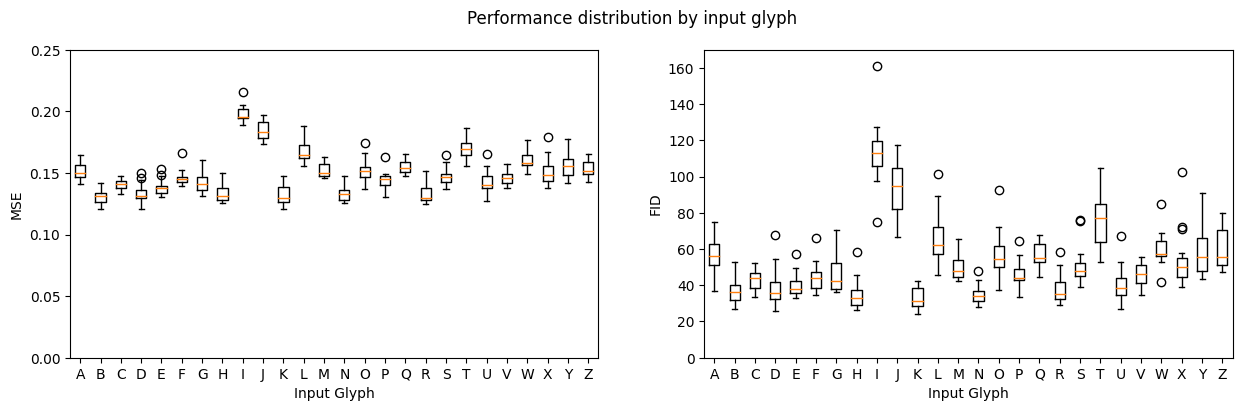

In [34]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/skeleton_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)


fig, (ax1, ax2) = plot.subplots(1, 2,figsize = (15,4))
fig.suptitle('Performance distribution by input glyph')
ax1.boxplot(mse_list, labels=list(string.ascii_uppercase))
ax2.boxplot(fid_list, labels=list(string.ascii_uppercase))
ax1.set_ylabel('MSE')
ax2.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax2.set_xlabel('Input Glyph')
ax1.set_ylim([0,0.25])
ax2.set_ylim([0,170])
plot.show()

# Summary Experiment 1

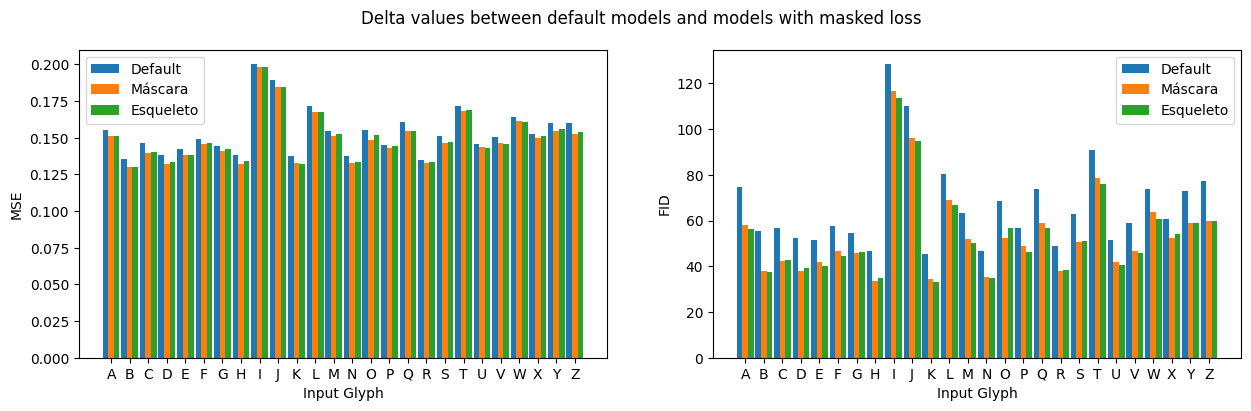

In [13]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]

#mse
default_values_mse=[[value for value in values['mse']['default'][letter]] for letter in string.ascii_uppercase]
default_values_mse=[sum(sequence) / len(sequence) for sequence in default_values_mse]

mask_values_mse=[[value for value in values['mse']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_mse=[sum(sequence) / len(sequence) for sequence in mask_values_mse]

skeleton_values_mse=[[value for value in values['mse']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_mse=[sum(sequence) / len(sequence) for sequence in skeleton_values_mse]

#fid
default_values_fid=[[value for value in values['fid']['default'][letter]] for letter in string.ascii_uppercase]
default_values_fid=[sum(sequence) / len(sequence) for sequence in default_values_fid]

mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

#plot all
X = list(string.ascii_uppercase)
X_axis = np.arange(len(X))

fig, (ax1, ax2) = plot.subplots(1, 2,figsize = (15,4))
fig.suptitle('Delta values between default models and models with masked loss')
ax1.bar(X_axis - 0.3, default_values_mse, 0.3, label = 'Default')
ax1.bar(X_axis + 0.0, mask_values_mse, 0.3, label = 'Máscara')
ax1.bar(X_axis + 0.3, skeleton_values_mse, 0.3, label = 'Esqueleto')

ax2.bar(X_axis - 0.3, default_values_fid, 0.3, label = 'Default')
ax2.bar(X_axis + 0.0, mask_values_fid, 0.3, label = 'Máscara')
ax2.bar(X_axis + 0.3, skeleton_values_fid, 0.3, label = 'Esqueleto')

ax1.set_xticks(X_axis, X)
ax2.set_xticks(X_axis, X)
ax1.set_ylabel('MSE')
ax2.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax2.set_xlabel('Input Glyph')
ax1.legend()
ax2.legend()
plot.show()

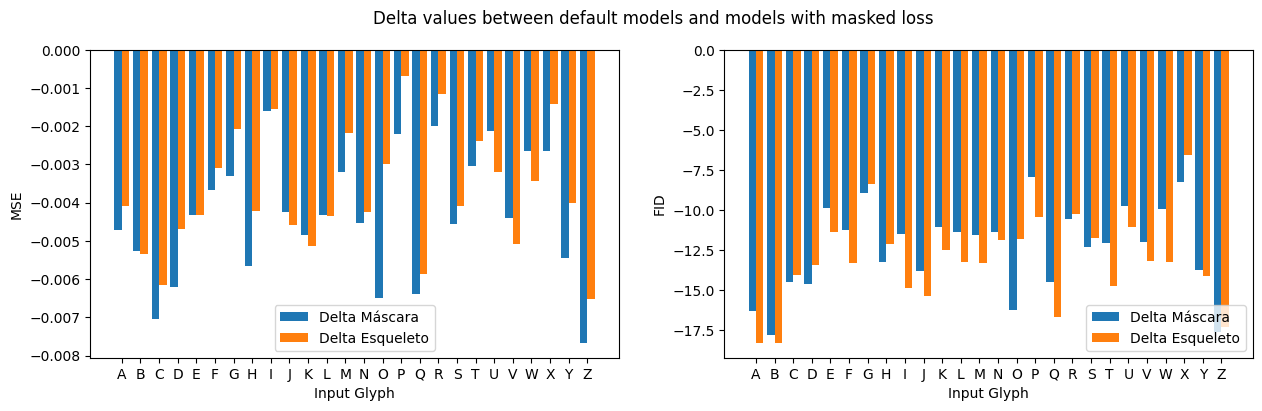

In [15]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]

#mse
default_values_mse=[[value for value in values['mse']['default'][letter]] for letter in string.ascii_uppercase]
default_values_mse=[sum(sequence) / len(sequence) for sequence in default_values_mse]

mask_values_mse=[[value for value in values['mse']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_mse=[sum(sequence) / len(sequence) for sequence in mask_values_mse]

skeleton_values_mse=[[value for value in values['mse']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_mse=[sum(sequence) / len(sequence) for sequence in skeleton_values_mse]

diff1_mse=[mask_values_mse[i]-default_values_mse[i] for i in range(len(default_values_mse))]
diff2_mse=[skeleton_values_mse[i]-default_values_mse[i] for i in range(len(default_values_mse))]
diff3_mse=[skeleton_values_mse[i]-mask_values_mse[i] for i in range(len(default_values_mse))]

#fid
default_values_fid=[[value for value in values['fid']['default'][letter]] for letter in string.ascii_uppercase]
default_values_fid=[sum(sequence) / len(sequence) for sequence in default_values_fid]

mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

diff1_fid=[mask_values_fid[i]-default_values_fid[i] for i in range(len(default_values_fid))]
diff2_fid=[skeleton_values_fid[i]-default_values_fid[i] for i in range(len(default_values_fid))]
diff3_fid=[skeleton_values_fid[i]-mask_values_fid[i] for i in range(len(default_values_fid))]
#plot all
X = list(string.ascii_uppercase)
X_axis = np.arange(len(X))

fig, (ax1, ax2) = plot.subplots(1, 2,figsize = (15,4))
fig.suptitle('Delta values between default models and models with masked loss')
ax1.bar(X_axis - 0.2, diff1_mse, 0.4, label = 'Delta Máscara')
ax1.bar(X_axis + 0.2, diff2_mse, 0.4, label = 'Delta Esqueleto')
ax2.bar(X_axis - 0.2, diff1_fid, 0.4, label = 'Delta Máscara')
ax2.bar(X_axis + 0.2, diff2_fid, 0.4, label = 'Delta Esqueleto')
ax1.set_xticks(X_axis, X)
ax2.set_xticks(X_axis, X)
ax1.set_ylabel('MSE')
ax2.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax2.set_xlabel('Input Glyph')
ax1.legend()
ax2.legend()
plot.show()

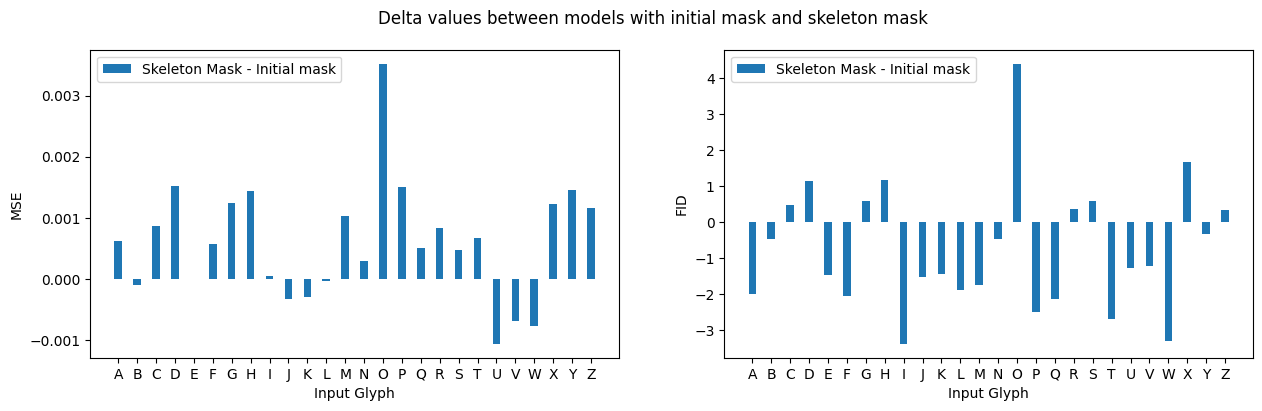

In [16]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]

#mse
mask_values_mse=[[value for value in values['mse']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_mse=[sum(sequence) / len(sequence) for sequence in mask_values_mse]

skeleton_values_mse=[[value for value in values['mse']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_mse=[sum(sequence) / len(sequence) for sequence in skeleton_values_mse]

diff3_mse=[skeleton_values_mse[i]-mask_values_mse[i] for i in range(len(default_values_mse))]

#fid
mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

diff3_fid=[skeleton_values_fid[i]-mask_values_fid[i] for i in range(len(default_values_fid))]
#plot all
X = list(string.ascii_uppercase)
X_axis = np.arange(len(X))

fig, (ax1, ax2) = plot.subplots(1, 2,figsize = (15,4))
fig.suptitle('Delta values between models with initial mask and skeleton mask')
ax1.bar(X_axis, diff3_mse, 0.4, label = 'Skeleton Mask - Initial mask')
ax2.bar(X_axis, diff3_fid, 0.4, label = 'Skeleton Mask - Initial mask')

ax1.set_xticks(X_axis, X)
ax2.set_xticks(X_axis, X)
ax1.set_ylabel('MSE')
ax2.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax2.set_xlabel('Input Glyph')
ax1.legend()
ax2.legend()
plot.show()

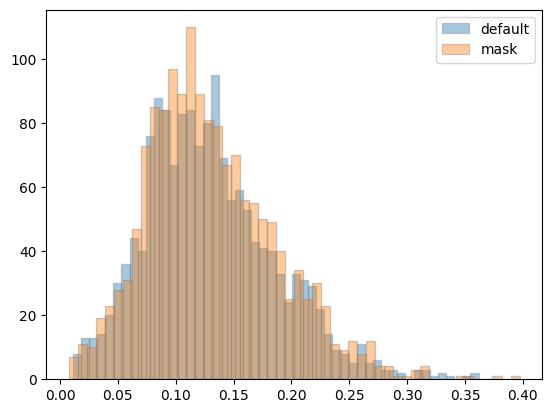

In [20]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]

letter='R'
seed=0
alpha=0.4
values_1=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}.txt").readlines()[1:]]
values_2=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment1/mask_seed_{seed}/{letter}.txt").readlines()[1:]]
values_3=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment1/skeleton_seed_{seed}/{letter}.txt").readlines()[1:]]


bins = np.linspace(0, 100, 1)
fig, ax1 = plot.subplots()
ax1.hist(values_1, bins=50, label='default', alpha=alpha,edgecolor='gray', linewidth=1)
ax1.hist(values_2, bins=50, label='mask', alpha=alpha,edgecolor='gray', linewidth=1)
#ax1.hist(values_3, bins=50, label='skeleton', alpha=0.2,edgecolor='gray', linewidth=1)
plot.legend()
plot.show()




# Subsets experiment

In [ ]:
#--------- Generate Test Samples
#Compute MSE and SSIM for each output alongside the overall mean and FID on whole dataset

for seed in range(0,15):
        for letter in list(string.ascii_uppercase):
                config=conf_experiment2_var1()
                config['logname']=f'subset_1_seed_{seed}'
                config['seed']=seed
                test_with_metrics(config,'data.txt')

for seed in range(0,15):
        for letter in list(string.ascii_uppercase):
                config=conf_experiment2_var2()
                config['logname']=f'subset_2_seed_{seed}'
                config['seed']=seed
                test_with_metrics(config,'data.txt')

## Scatter plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


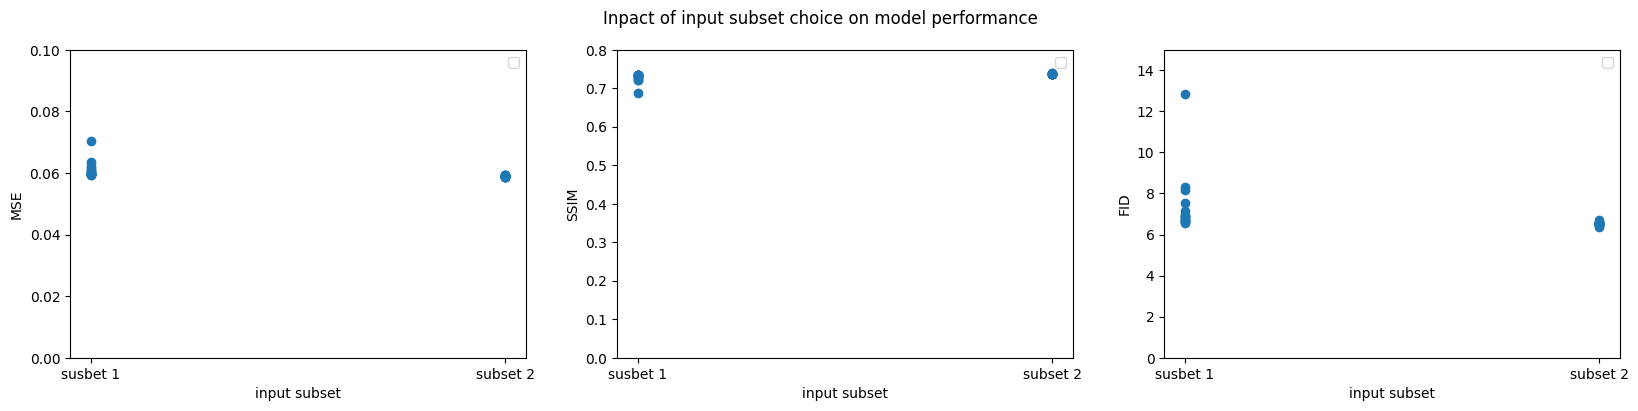

In [39]:
values={'mse':{'1':[],'2':[]}, 'fid':{'1':[],'2':[]}, 'ssim':{'1':[],'2':[]} }

for model in ['1','2']:
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment2/subset_{model}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][model]+=[float(fid)]
            values['mse'][model]+=[float(mse)]
            values['ssim'][model]+=[float(ssim)]


scatter_x_mse=[1 for i in range(15)]+ [2 for i in range(15)]
scatter_y_mse=values['mse']['1'] + values['mse']['2']

scatter_x_ssim=[1 for i in range(15)]+ [2 for i in range(15)]
scatter_y_ssim=values['ssim']['1'] + values['ssim']['2']

scatter_x_fid=[1 for i in range(15)]+ [2 for i in range(15)]
scatter_y_fid=values['fid']['1'] + values['fid']['2']

fig, (ax1, ax2,ax3) = plot.subplots(1, 3,figsize = (20,4))
fig.suptitle('Inpact of input subset choice on model performance')

ax1.scatter(x=scatter_x_mse,y=scatter_y_mse)
ax2.scatter(x=scatter_x_ssim,y=scatter_y_ssim)
ax3.scatter(x=scatter_x_fid,y=scatter_y_fid)

ax1.set_xticks([1,2], ['susbet 1', 'subset 2'])
ax2.set_xticks([1,2], ['susbet 1', 'subset 2'])
ax3.set_xticks([1,2], ['susbet 1', 'subset 2'])

ax1.set_xlabel('input subset')
ax1.set_ylabel('MSE')
ax1.set_ylim([0,0.1])

ax2.set_xlabel('input subset')
ax2.set_ylabel('SSIM')
ax2.set_ylim([0,0.8])


ax3.set_xlabel('input subset')
ax3.set_ylabel('FID')
ax3.set_ylim([0,15])

ax1.legend()
ax2.legend()
ax3.legend()
plot.show()

In [3]:
values={'mse':{'1':[],'2':[]}, 'fid':{'1':[],'2':[]}, 'ssim':{'1':[],'2':[]} }
round_value=4
for model in ['1','2']:
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment2/subset_{model}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][model]+=[float(fid)]
            values['mse'][model]+=[float(mse)]
            values['ssim'][model]+=[float(ssim)]

for seed in range(0,15):
    print(f"{seed} & {round(values['mse']['1'][seed],round_value)} & {round(values['fid']['1'][seed],round_value)} & {round(values['ssim']['1'][seed],round_value)} & {round(values['mse']['2'][seed],round_value)} & {round(values['fid']['2'][seed],round_value)} & {round(values['ssim']['2'][seed],round_value)}\\\\")

print(f"{np.round(np.mean(np.array(values['mse']['1'])),round_value)} & {np.round(np.mean(np.array(values['fid']['1'])),round_value)} & {np.round(np.mean(np.array(values['ssim']['1'])),round_value)} & {np.round(np.mean(np.array(values['mse']['2'])),round_value)} & {np.round(np.mean(np.array(values['fid']['2'])),round_value)} & {np.round(np.mean(np.array(values['ssim']['2'])),round_value)}")  
print(f"{np.round(np.std(np.array(values['mse']['1'])),round_value)} & {np.round(np.std(np.array(values['fid']['1'])),round_value)} & {np.round(np.std(np.array(values['ssim']['1'])),round_value)} & {np.round(np.std(np.array(values['mse']['2'])),round_value)} & {np.round(np.std(np.array(values['fid']['2'])),round_value)} & {np.round(np.std(np.array(values['ssim']['2'])),round_value)}")      

0 & 0.0596 & 6.6434 & 0.7335 & 0.0587 & 6.552 & 0.7374\\
1 & 0.0596 & 6.7307 & 0.734 & 0.0587 & 6.5609 & 0.7374\\
2 & 0.0594 & 6.5571 & 0.7356 & 0.0589 & 6.693 & 0.7378\\
3 & 0.0595 & 6.6814 & 0.7347 & 0.0589 & 6.5318 & 0.737\\
4 & 0.0596 & 6.8341 & 0.7339 & 0.0587 & 6.5486 & 0.7368\\
5 & 0.0608 & 7.1605 & 0.7291 & 0.0589 & 6.4504 & 0.7378\\
6 & 0.0634 & 8.3176 & 0.7203 & 0.059 & 6.5633 & 0.7367\\
7 & 0.0607 & 6.9373 & 0.7312 & 0.0588 & 6.3811 & 0.7383\\
8 & 0.0617 & 7.545 & 0.7271 & 0.0593 & 6.5352 & 0.7362\\
9 & 0.0703 & 12.8269 & 0.688 & 0.0592 & 6.4635 & 0.737\\
10 & 0.0622 & 8.1794 & 0.7209 & 0.0593 & 6.5588 & 0.7363\\
11 & 0.0595 & 6.5892 & 0.7351 & 0.0586 & 6.4783 & 0.7385\\
12 & 0.0599 & 6.8887 & 0.7331 & 0.0593 & 6.5775 & 0.7365\\
13 & 0.0598 & 6.7213 & 0.7337 & 0.059 & 6.5226 & 0.737\\
14 & 0.0598 & 6.7838 & 0.734 & 0.059 & 6.6056 & 0.7374\\
0.0611 & 7.4264 & 0.7283 & 0.059 & 6.5348 & 0.7372
0.0027 & 1.5386 & 0.0117 & 0.0002 & 0.0701 & 0.0007


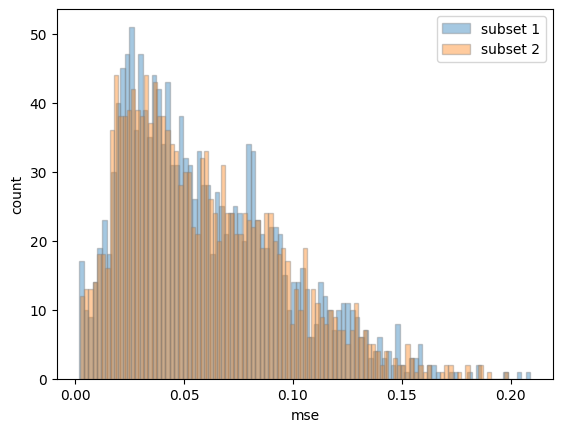

In [22]:
seed=0
alpha=0.4
values_1=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment2/subset_1_seed_{seed}/data.txt").readlines()[1:]]
values_2=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment2/subset_2_seed_{seed}/data.txt").readlines()[1:]]

fig, ax1 = plot.subplots()
ax1.hist(values_1, bins=100, label='subset 1', alpha=alpha,edgecolor='gray', linewidth=1)
ax1.hist(values_2, bins=100, label='subset 2', alpha=alpha,edgecolor='gray', linewidth=1)
#ax1.hist(values_3, bins=50, label='skeleton', alpha=0.2,edgecolor='gray', linewidth=1)
ax1.set_ylabel('count')
ax1.set_xlabel('mse')
plot.legend()
plot.show()

# Input Subset Experiment

In [ ]:
#--------- Generate Test Samples
#Compute MSE and SSIM for each output alongside the overall mean and FID on whole dataset

for seed in range(0,5):
        for k in range(3,10):
                config=conf_experiment3()
                config['logname']=f'default_n_{k}_seed_{seed}'
                config['n_visible']=k
                config['glyphs_visible']=None
                config['seed']=seed
                test_with_metrics(config,'data.txt')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


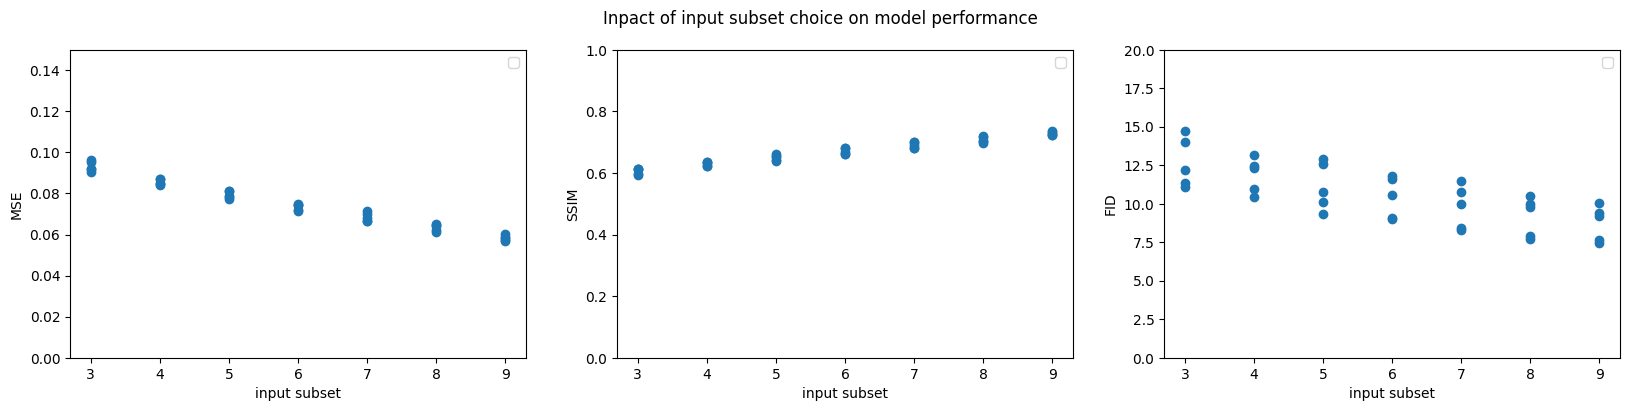

In [29]:
values={'mse':{i:[] for i in range(3,10)}, 'fid':{i:[] for i in range(3,10)}, 'ssim':{i:[] for i in range(3,10)} }

for k in range(3,10):
        for seed in range(0,5):
            file=open(f"/home/francisco/logs/experiment3/default_n_{k}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][k]+=[float(fid)]
            values['mse'][k]+=[float(mse)]
            values['ssim'][k]+=[float(ssim)]


scatter_x_mse=[[i]*5 for i in range(3,10)]
scatter_y_mse=[values['mse'][k] for k in range(3,10)]

scatter_x_ssim=[[i]*5 for i in range(3,10)]
scatter_y_ssim=[values['ssim'][k] for k in range(3,10)]

scatter_x_fid=[[i]*5 for i in range(3,10)]
scatter_y_fid=[values['fid'][k] for k in range(3,10)]

fig, (ax1, ax2,ax3) = plot.subplots(1, 3,figsize = (20,4))
fig.suptitle('Inpact of input subset choice on model performance')

ax1.scatter(x=scatter_x_mse,y=scatter_y_mse)
ax2.scatter(x=scatter_x_ssim,y=scatter_y_ssim)
ax3.scatter(x=scatter_x_fid,y=scatter_y_fid)

ax1.set_xlabel('input subset')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 0.15])

ax2.set_xlabel('input subset')
ax2.set_ylabel('SSIM')
ax2.set_ylim([0, 1])

ax3.set_xlabel('input subset')
ax3.set_ylabel('FID')
ax3.set_ylim([0, 20])

ax1.legend()
ax2.legend()
ax3.legend()
plot.show()

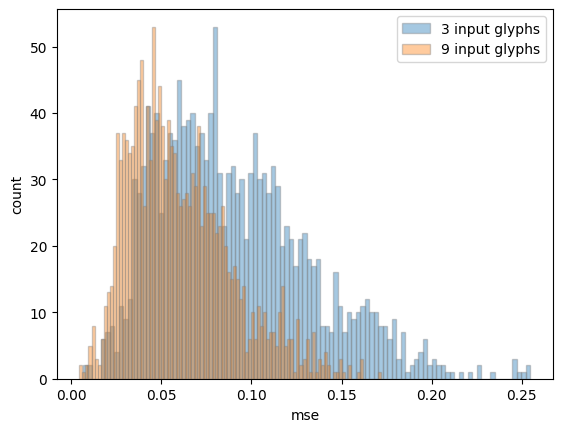

In [24]:
seed=0
alpha=0.4
values_1=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment3/default_n_3_seed_{seed}/data.txt").readlines()[1:]]
values_2=[float(values.strip().split('\t')[1]) for values in open(f"/home/francisco/logs/experiment3/default_n_9_seed_{seed}/data.txt").readlines()[1:]]

fig, ax1 = plot.subplots()
ax1.hist(values_1, bins=100, label='3 input glyphs', alpha=alpha,edgecolor='gray', linewidth=1)
ax1.hist(values_2, bins=100, label='9 input glyphs', alpha=alpha,edgecolor='gray', linewidth=1)
#ax1.hist(values_3, bins=50, label='skeleton', alpha=0.2,edgecolor='gray', linewidth=1)
ax1.set_ylabel('count')
ax1.set_xlabel('mse')
plot.legend()
plot.show()

## Build Visuals

In [5]:
target_folder='/home/francisco/dataset/capitals64/test'
generated_folder1='/home/francisco/logs/experiment4/var1_seed_0/test'
generated_folder2='/home/francisco/logs/diffusion/default_conditional/test_flat'
device="cuda:0"
input_glyphs=[7, 14, 3, 18, 6, 17]
batch_size=11

for h,start_idx in enumerate(range(0, len(os.listdir(target_folder)),batch_size)):
    
    image=torch.ones(size=(3,1,1664),device=device, requires_grad=False)

    for name in tqdm(os.listdir(target_folder)[start_idx:start_idx+batch_size]):
        target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
        target=torch.cat((target,target,target),dim=0)

        for elem in input_glyphs:
            target=draw_red_square(target,startX=0,startY=64*elem,width=64)
        
        generated1=load_image_to_tensor(os.path.join(generated_folder1, name), unsqueeze=False, device=device)
        generated1=torch.cat((generated1,generated1,generated1),dim=0)

        generated2=load_image_to_tensor(os.path.join(generated_folder2, name), unsqueeze=False, device=device)
        generated2=torch.cat((generated2,generated2,generated2),dim=0)

        parcel=torch.cat((target,generated1),dim=1)
        parcel=torch.cat((parcel,generated2),dim=1)
        
        image=torch.cat((image,torch.ones(size=(3,64,1664),device=device)),dim=1)
        image=torch.cat((image,parcel),dim=1)

    save_image(image, f'/home/francisco/logs/visuals/visuals_{h}.png')
    

100%|██████████| 15/15 [00:00<00:00, 276.76it/s]


100%|██████████| 15/15 [00:00<00:00, 311.68it/s]


In [31]:
target_folder='/home/francisco/dataset/daniel26/test'
generated_folder='/home/francisco/logs/experiment4/Train_Combined/test'
device="cuda:0"
input_glyphs=[7, 14, 3, 18, 6, 17]
batch_size=100

for start_idx in range(0, len(os.listdir(target_folder)),batch_size):
    
    image=torch.ones(size=(3,64,1664),device=device, requires_grad=False)

    for name in tqdm(os.listdir(target_folder)[start_idx:start_idx+batch_size]):
        target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
        target=torch.cat((target,target,target),dim=0)

        for elem in input_glyphs:
            target=draw_red_square(target,startX=0,startY=64*elem,width=64)
        
        generated=load_image_to_tensor(os.path.join(generated_folder, name), unsqueeze=False, device=device)
        generated=torch.cat((generated,generated,generated),dim=0)

        parcel=torch.cat((target,generated),dim=1)
        
        image=torch.cat((image,torch.ones(size=(3,64,1664),device=device)),dim=1)
        image=torch.cat((image,parcel),dim=1)

    save_image(image, f'/home/francisco/logs/experiment4/Train_Combined/visuals_{start_idx}.png')

100%|██████████| 70/70 [00:00<00:00, 363.57it/s]


In [ ]:
target_folder='/home/francisco/mc-gan/datasets/Capitals64/test'
generated_folder='/home/francisco/logs/experiment4/Train_Combined/test'
device="cuda:0"
input_glyphs=[7, 14, 3, 18, 6, 17]
batch_size=100

for start_idx in range(0, len(os.listdir(target_folder)),batch_size):
    
    image=torch.ones(size=(3,64,1664),device=device, requires_grad=False)

    for name in tqdm(os.listdir(target_folder)[start_idx:start_idx+batch_size]):
        target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
        target=torch.cat((target,target,target),dim=0)

        for elem in input_glyphs:
            target=draw_red_square(target,startX=0,startY=64*elem,width=64)
        
        generated=load_image_to_tensor(os.path.join(generated_folder, name), unsqueeze=False, device=device)
        generated=torch.cat((generated,generated,generated),dim=0)

        parcel=torch.cat((target,generated),dim=1)
        
        image=torch.cat((image,torch.ones(size=(3,64,1664),device=device)),dim=1)
        image=torch.cat((image,parcel),dim=1)

    save_image(image, f'/home/francisco/logs/experiment4/Train_Combined/visuals_{start_idx}.png')

In [10]:
batch_size=50
to_be_visible=[10,7,1,13,17,3,15,14,18]
seed=0
"""
for k in tqdm(range(3,10)):
    config=conf_experiment3()
    config['path_log']= '../logs/experiment3'
    config['logname']=f'default_n_{k}_seed_{seed}'
    config['seed']=0
    config['glyphs_visible']=[]
    for elem in list(range(26)):
        if elem in to_be_visible[0:k]:
            config['glyphs_visible'].append(elem)
    config['n_visible']=k

    test_with_metrics(config,text_file_name='data.txt')

"""
target_folder='/home/francisco/mc-gan/datasets/Capitals64/test'
device='cuda:0'
for start_idx in range(0, len(os.listdir(target_folder)),batch_size):
    image=torch.ones(size=(3,64,1664),device=device, requires_grad=False)

    for name in tqdm(os.listdir(target_folder)[start_idx:start_idx+batch_size]):
        target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
        target=torch.cat((target,target,target),dim=0)
        
        for k in range(3,10):
            generated_folder=f'/home/francisco/logs/experiment3/default_n_{k}_seed_{seed}/test'
            generated=load_image_to_tensor(os.path.join(generated_folder, name), unsqueeze=False, device=device)
            generated=torch.cat((generated,generated,generated),dim=0)
            for elem in to_be_visible[0:k]:
                generated=draw_red_square(generated,startX=0,startY=64*elem,width=64)
            

            target=torch.cat((target,generated),dim=1)
        image=torch.cat((image,target),dim=1)
        image=torch.cat((image,torch.ones(size=(3,64,1664),device=device)),dim=1)

    save_image(image, f'/home/francisco/logs/experiment3/visuals_{start_idx}.png')
    

100%|██████████| 10/10 [00:00<00:00, 62.47it/s]


## Visuals for any data.txt

In [18]:
targets_path='/home/francisco/dataset/daniel26/all'
generated_path='/home/francisco/logs/experiment4/Train_Capitals64/test'
filename='/home/francisco/logs/experiment4/Train_Capitals64/data.txt'
destination_path='/home/francisco/logs/experiment4/Train_Capitals64/representative.png'
metric='ssim'
group_size=50
device='cuda:0'
input_glyphs=[    7,    14,    3,    18,    6,    17  ]

f=open(filename,'r')
lines=f.readlines()
lines=[line.strip().split('\t') for line in lines[1:]]
if metric=='mse':
    data=[float(line[1]) for line in lines]
elif metric=='ssim':
    data=[float(line[2]) for line in lines]
else:
    raise Exception
names=[line[0] for line in lines]

image=torch.ones(size=(3,1,64*26),device=device)

data=np.array(data)
indxs=np.argsort(data)

#-------------Lowest Values--------------
for i,elem in enumerate(indxs[0:group_size]):
    targets=load_image_to_tensor(os.path.join(targets_path,f'{names[elem]}.png'),unsqueeze=False,device='cuda:0')
    targets=torch.cat((targets,targets,targets),dim=0)

    generated=load_image_to_tensor(os.path.join(generated_path,f'{names[elem]}.png'),unsqueeze=False,device='cuda:0')
    generated=torch.cat((generated,generated,generated),dim=0)
    for elem in input_glyphs:
        generated=draw_red_square(generated,0,elem*64,64)

    image=torch.cat((image,targets),dim=1)
    image=torch.cat((image,generated),dim=1)
    
    image=torch.cat((image,torch.ones(size=(3,20,64*26),device=device)),dim=1)

#-------------Median Values--------------
image=torch.cat((image,torch.ones(size=(3,128,64*26),device=device)),dim=1)
for i,elem in enumerate(indxs[round(len(indxs)/2)-group_size:round(len(indxs)/2)]):
    targets=load_image_to_tensor(os.path.join(targets_path,f'{names[elem]}.png'),unsqueeze=False,device='cuda:0')
    targets=torch.cat((targets,targets,targets),dim=0)

    generated=load_image_to_tensor(os.path.join(generated_path,f'{names[elem]}.png'),unsqueeze=False,device='cuda:0')
    generated=torch.cat((generated,generated,generated),dim=0)
    for elem in input_glyphs:
        generated=draw_red_square(generated,0,elem*64,64)

    image=torch.cat((image,targets),dim=1)
    image=torch.cat((image,generated),dim=1)
    
    image=torch.cat((image,torch.ones(size=(3,20,64*26),device=device)),dim=1)

#-------------Highest Values--------------
image=torch.cat((image,torch.ones(size=(3,128,64*26),device=device)),dim=1)
for i,elem in enumerate(indxs[-group_size:]):
    targets=load_image_to_tensor(os.path.join(targets_path,f'{names[elem]}.png'),unsqueeze=False,device='cuda:0')
    targets=torch.cat((targets,targets,targets),dim=0)

    generated=load_image_to_tensor(os.path.join(generated_path,f'{names[elem]}.png'),unsqueeze=False,device='cuda:0')
    generated=torch.cat((generated,generated,generated),dim=0)
    for elem in input_glyphs:
        generated=draw_red_square(generated,0,elem*64,64)

    image=torch.cat((image,targets),dim=1)
    image=torch.cat((image,generated),dim=1)
    
    image=torch.cat((image,torch.ones(size=(3,20,64*26),device=device)),dim=1)


save_image(image,destination_path)


## Random Samples from a given dataset

In [6]:
dataset_path='/home/francisco/dataset/daniel26/train'
destination_path='/home/francisco/dataset/samples.png'
n_samples=20
device='cuda:0'

names=os.listdir(dataset_path)
selected=random.sample(names,k=n_samples)

image=torch.ones(size=(1,1,64*26),device=device)
for i,elem in enumerate(selected):
    targets=load_image_to_tensor(os.path.join(dataset_path,elem),unsqueeze=False,device='cuda:0')
    image=torch.cat((image,torch.ones(size=(1,5,64*26),device=device)),dim=1)
    image=torch.cat((image,targets),dim=1)

save_image(image,destination_path)


In [6]:
# /home/francisco/mc-gan/datasets/Capitals64/test
names=os.listdir('/home/francisco/mc-gan/datasets/Capitals64/val')
print(1560+9122+1473)

12155


# Paper Scripts

In [19]:
font='/home/francisco/dataset/capitals64Original/test/47.png'
default_font='/home/francisco/mc-gan/datasets/Capitals64/BASE/Code New Roman.0.0.png'
device='cpu'
glyph=19


image=load_image_to_tensor(source_path=font,unsqueeze=False,device='cpu')
image_folded = fold_image(image)

default_font = load_image_to_tensor(default_font, unsqueeze=False, device='cpu')
default_font = fold_image(default_font)

default_mask = attention_mask_from_font(image_folded, default_font, True, 0.1)[glyph,:,:]
default_mask=InvertTransform()(default_mask)

skeleton = get_skeleton(image_folded[glyph,:,:], False, kernel_size= 1, sigma=2 ,lower_limit= 0).squeeze(0)
skeleton_mask=detect_poinsts(skeleton, True, 1, 0, kernel_size=3, sigma=1)
skeleton_mask=InvertTransform()(skeleton_mask)

save_image(skeleton_mask, '/home/francisco/dataset/skeleton.png')
save_image(default_mask, '/home/francisco/dataset/mask.png')
save_image(image[:,:,glyph*64:(glyph+1)*64], '/home/francisco/dataset/glyph.png')

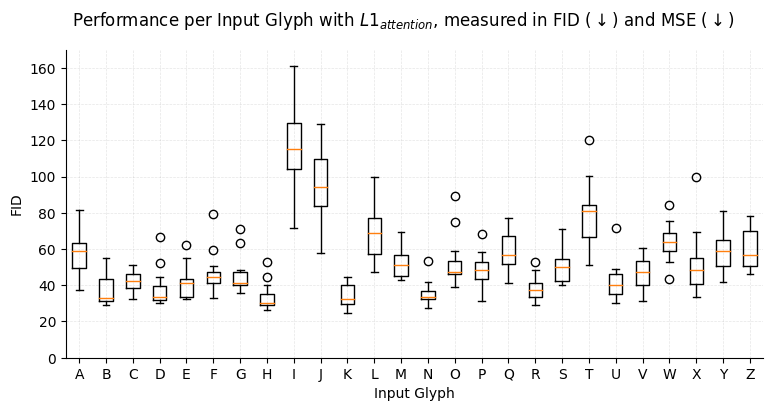

In [24]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/mask_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)

fig, ax = plot.subplots(figsize = (9,4))
fig.suptitle('Performance per Input Glyph with $L1_{attention}$, measured in FID ($\downarrow$) and MSE ($\downarrow$)')
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.2)
ax.boxplot(fid_list, labels=list(string.ascii_uppercase))
ax.set_ylabel('FID')
ax.set_xlabel('Input Glyph')
ax.set_ylim([0,170])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plot.show()

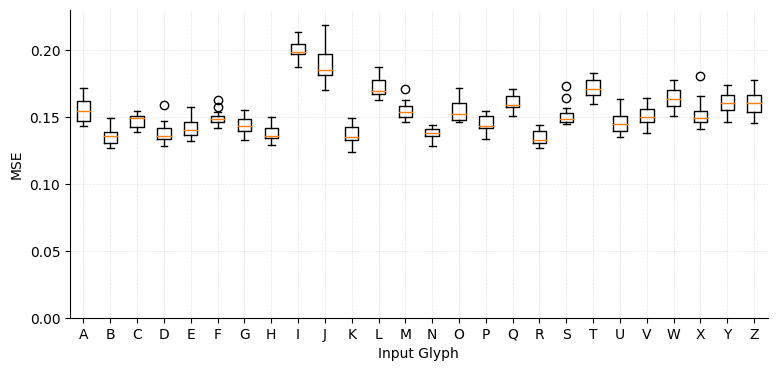

In [11]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)

fig, ax = plot.subplots(figsize = (9,4))
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.2)
ax.boxplot(mse_list, labels=list(string.ascii_uppercase))
ax.set_ylabel('MSE')
ax.set_xlabel('Input Glyph')
ax.set_ylim([0,0.23])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plot.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
27


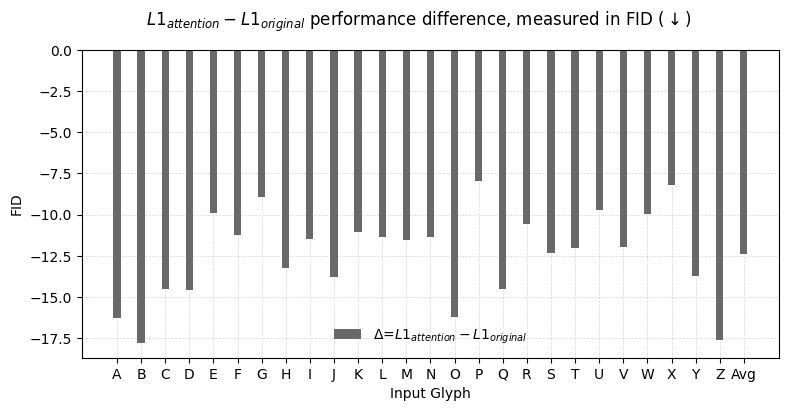

In [7]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]

#mse
default_values_mse=[[value for value in values['mse']['default'][letter]] for letter in string.ascii_uppercase]
default_values_mse=[sum(sequence) / len(sequence) for sequence in default_values_mse]

mask_values_mse=[[value for value in values['mse']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_mse=[sum(sequence) / len(sequence) for sequence in mask_values_mse]

skeleton_values_mse=[[value for value in values['mse']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_mse=[sum(sequence) / len(sequence) for sequence in skeleton_values_mse]

diff1_mse=[mask_values_mse[i]-default_values_mse[i] for i in range(len(default_values_mse))]
diff2_mse=[skeleton_values_mse[i]-default_values_mse[i] for i in range(len(default_values_mse))]
diff3_mse=[skeleton_values_mse[i]-mask_values_mse[i] for i in range(len(default_values_mse))]

#fid
default_values_fid=[[value for value in values['fid']['default'][letter]] for letter in string.ascii_uppercase]
default_values_fid=[sum(sequence) / len(sequence) for sequence in default_values_fid]

mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

diff1_fid=[mask_values_fid[i]-default_values_fid[i] for i in range(len(default_values_fid))]
avg=np.mean(np.array(diff1_fid))
diff2_fid=[skeleton_values_fid[i]-default_values_fid[i] for i in range(len(default_values_fid))]
diff3_fid=[skeleton_values_fid[i]-mask_values_fid[i] for i in range(len(default_values_fid))]
#plot all
X = list(string.ascii_uppercase)+['Avg']
X_axis = np.arange(len(X))
fig, ax1 = plot.subplots(figsize = (9,4))
fig.suptitle('$L1_{attention} -  L1_{original}$ performance difference, measured in FID ($\downarrow$)')
ax1.set_axisbelow(True)
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.3)
ax1.bar(X_axis, diff1_fid+ [avg], 0.3, label = '$\Delta \equal L1_{attention} -  L1_{original}$', color='dimgray')
ax1.set_xticks(X_axis, X)
ax1.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax1.legend(loc='best',  framealpha=0.0)
plot.show()

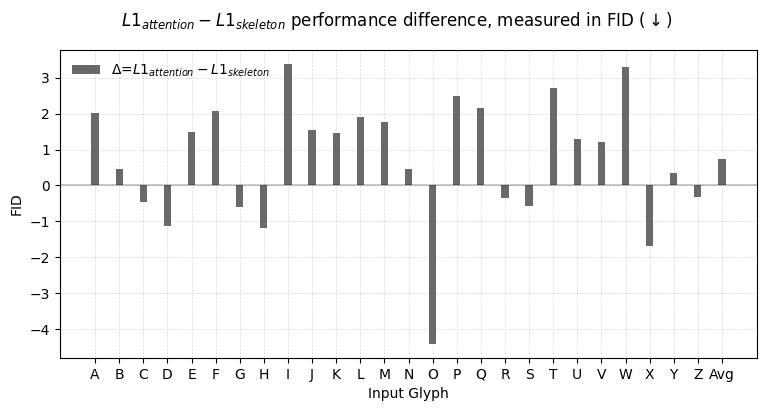

In [8]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]


#fid
mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

diff3_fid=[mask_values_fid[i]-skeleton_values_fid[i] for i in range(len(skeleton_values_fid))]
#plot all
X = list(string.ascii_uppercase)+['Avg']
X_axis = np.arange(len(X))

avg=np.mean(np.array(diff3_fid))
fig, ax1 = plot.subplots(figsize = (9,4))
fig.suptitle('$L1_{attention} -  L1_{skeleton}$ performance difference, measured in FID ($\downarrow$)')
ax1.set_axisbelow(True)
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.3)
ax1.bar(X_axis, diff3_fid+ [avg], 0.3, label = '$\Delta \equal L1_{attention} -  L1_{skeleton}$', color='dimgray')
ax1.axhline(y = 0, color = 'black', linestyle = '-', linewidth=0.3)
ax1.set_xticks(X_axis, X)
ax1.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax1.legend(loc='best',  framealpha=0.0)
plot.show()


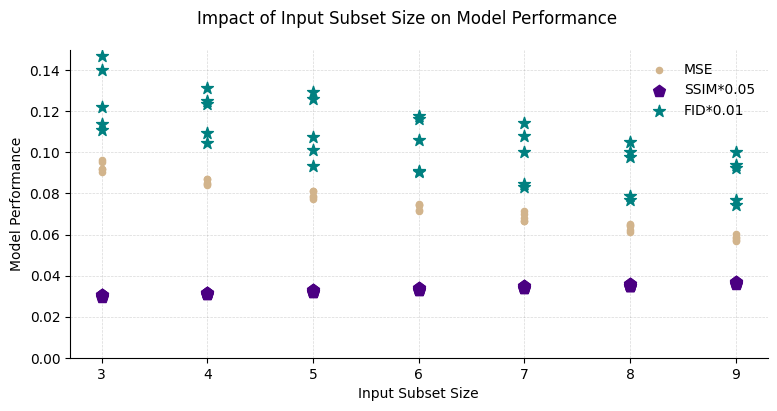

In [7]:
values={'mse':{i:[] for i in range(3,10)}, 'fid':{i:[] for i in range(3,10)}, 'ssim':{i:[] for i in range(3,10)} }

for k in range(3,10):
        for seed in range(0,5):
            file=open(f"/home/francisco/logs/experiment3/default_n_{k}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][k]+=[float(fid)]
            values['mse'][k]+=[float(mse)]
            values['ssim'][k]+=[float(ssim)]


scatter_x_mse=[[i]*5 for i in range(3,10)]
scatter_y_mse=[values['mse'][k] for k in range(3,10)]

scatter_x_ssim=[[i]*5 for i in range(3,10)]
scatter_y_ssim=[values['ssim'][k] for k in range(3,10)]

scatter_x_fid=[[i]*5 for i in range(3,10)]
scatter_y_fid=[values['fid'][k] for k in range(3,10)]

fig, ax1 = plot.subplots(figsize = (9,4))
fig.suptitle('Impact of Input Subset Size on Model Performance')

fid_scale=0.01
ssim_scale=0.05
point_size=80
ax1.scatter(x=scatter_x_mse,y=scatter_y_mse, label = 'MSE', s=point_size, marker=".", color='tan')
ax1.scatter(x=scatter_x_ssim,y=[[x*ssim_scale for x  in seq] for seq in scatter_y_ssim], label = f'SSIM*{ssim_scale}', s=point_size, marker="p", color="indigo")
ax1.scatter(x=scatter_x_fid,y=[[x*fid_scale for x  in seq] for seq in scatter_y_fid], label = f'FID*{fid_scale}', s=point_size, marker="*",color="teal")

ax1.set_ylabel('Model Performance')
ax1.set_xlabel('Input Subset Size')
ax1.set_axisbelow(True)
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.3)
ax1.set_ylim([0, 0.15])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(loc='best',  framealpha=0.0)
plot.show()

In [16]:
values={'1':[], '2':[]}

for model in ['1','2']:
    for seed in range(0,5):
        file=open(f"/home/francisco/logs/experiment2/subset_{model}_seed_{seed}/data.txt")
        lines=file.readlines()
        mse,ssim,fid= lines[0].strip().split()
        values[model]+=[float(mse)]

a=values['1']
b=values['2']

#test for  homogeneity of variance
print(levene(a,b))
        
#perform Kolmogorov-Smirnov test for normality of a
print(kstest(a, 'norm'))
#perform Kolmogorov-Smirnov test for normality of a
print(kstest(b, 'norm'))

#t-test
print(wilcoxon(a,b,alternative='greater'))

LeveneResult(statistic=0.161574892895625, pvalue=0.6982357993025902)
KstestResult(statistic=0.5237010265542434, pvalue=0.08384467406964366)
KstestResult(statistic=0.5234043382764021, pvalue=0.08415796419802948)
WilcoxonResult(statistic=15.0, pvalue=0.03125)


In [2]:
generated_folder='/home/francisco/logs/experiment4/Train_Original'
second_generated_folder='/home/francisco/logs/experiment2/subset_2_seed_0'

values_1=[float(values.strip().split('\t')[2]) for values in open(f"{os.path.join(second_generated_folder,'data.txt')}").readlines()[1:]]
values_2=[float(values.strip().split('\t')[2]) for values in open(f"{os.path.join(generated_folder,'data.txt')}").readlines()[1:]]

fonts=[values.strip().split('\t')[0] for values in open(f"{os.path.join(generated_folder,'data.txt')}").readlines()[1:]]
print(fonts)

values_1=np.array(values_1)
values_2=np.array(values_2)
fonts=np.array(fonts)

diff=values_1-values_2
indxs=np.argsort(diff)

for elem in fonts[indxs[-20:-1]]:
    print(f"\"{elem}\",")

['1980 portable.0.0', 'Tipos Pereira - LondrinaThin-Regular.0.0', 'Nirepnirun atsum.0.0', 'zero hour.0.0', 'Jura-Regular.0.0', 'KR Lil Note.0.0', 'VTCGoblinHandItalic.0.0', 'ArbuckleInlineNF.0.0', 'capacitor.0.0', 'LibreFranklin-ThinItalic.0.0', 'Corleone.0.0', 'Garineldo.0.0', 'ReasontoseeEvil.0.0', 'quanttap.0.0', 'Alef-Regular.0.0', 'PamelorI.0.0', 'Here we are now, entertain us.0.0', 'ToubibDemo-Medium.0.0', 'Panton-LightCaps.0.0', 'ALEWISDODI.0.0', 'neighbors_yard.0.0', 'Exo-Thin-Italic.0.0', 'Milton_Two.0.0', 'Streetwear.0.0', 'Erika Ormig.0.0', 'EvilOfFrankenstein-UltraBlack.0.0', 'Walbaum-Fraktur-Bold.0.0', 'Belepotan-Italic.0.0', 'kredit front.0.0', 'Zabars.0.0', 'collecto.0.0', 'Girth Control.0.0', 'ZaleskiCn.0.0', 'minisystem.0.0', 'NovaMono.0.0', 'JandaStylishMonogram.0.0', 'Majoris.0.0', 'FirepowerBB_ital.0.0', 'VTCGoblinHand.0.0', 'CarrickDancing.0.0', 'FSAUSTRIAL.0.0', 'firasanscondensed-light.0.0', 'troika.0.0', 'Dreamer.0.0', 'Flanker Griffo Italic.0.0', 'BLACKPLOTAN.0

In [3]:
target_folder='/home/francisco/mc-gan/datasets/Capitals64/test'
generated_folder='/home/francisco/logs/experiment4/Train_Original/test'
second_generated_folder='/home/francisco/logs/experiment2/subset_2_seed_0/test'

device="cuda:0"
input_glyphs=[7, 14, 3, 18, 6, 17]
"""
fonts=[
    "47-Bold.0.0",
    "1980 portable.0.0",
    "Adieresis, Odieresis & Aring 2.0.0",
    "advanced_led_board-7.0.0",
    "Alpha54.0.0",
    #"AnagramNFShadow.0.0",
    "Antique Book Cover.0.0",
    "ARACNE_regular_italic.0.0",
    "BeautySchoolDropoutII.0.0",
    "betsy flanagan.0.0",
    "blackout_sunrise-webfont.0.0",
    "brassknuckle.0.0",
    "brick_led-7.0.0",
    "computer_7.0.0",
    #"Cruickshank.0.0",
    "gosebmps.0.0",
    #Walbaum-Fraktur.0.0",
    #"yonder recoil.0.0",
    ]
"""
fonts=[
    "KARNIVSV.0.0",
    "kimberley bl.0.0",
    "Prabowo Presiden.0.0",
    "Tulisan Tangan 74 Italic.0.0",
    "vtks squares.0.0",
    "JandaSafeandSound.0.0",
    "recharge bd.0.0",
    "no clocks.0.0",
    "TPF Ploxx.0.0",
    "Kanalisirung.0.0",
    "POLYA.0.0",
    "kleptocracy titling cd lt.0.0",
    "SFPlanetaryOrbiter-BoldItal.0.0",
    "EdselFont.0.0",
    "Ripoff.0.0",
    "Its About Time.0.0",
    "gaposiso.0.0",
    "quanttap.0.0",
    "kleptocracy titling bd.0.0",
    ]

fonts=[font+'.png' for font in fonts]

image=torch.ones(size=(3,3,1664),device=device, requires_grad=False)

for name in tqdm(fonts):
    target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
    target=torch.cat((target,target,target),dim=0)

    for elem in input_glyphs:
        target=draw_red_square(target,startX=0,startY=64*elem,width=64)
    
    generated=load_image_to_tensor(os.path.join(second_generated_folder, name), unsqueeze=False, device=device)
    generated=torch.cat((generated,generated,generated),dim=0)

    parcel=torch.cat((target,generated),dim=1)

    generated=load_image_to_tensor(os.path.join(generated_folder, name), unsqueeze=False, device=device)
    generated=torch.cat((generated,generated,generated),dim=0)

    parcel=torch.cat((parcel,generated),dim=1)
    if name!=fonts[0]:
        image=torch.cat((image,torch.ones(size=(3,30,1664),device=device)),dim=1)
    else:
        image=torch.cat((image,torch.ones(size=(3,3,1664),device=device)),dim=1)
    image=torch.cat((image,parcel),dim=1)

save_image(image, f'/home/francisco/logs/experiment4/Train_Original/visuals.png')

100%|██████████| 19/19 [00:00<00:00, 134.48it/s]
